# MidiNet用データの作成，前処理

用意するデータ
- bar (N, steps, pitch_range)
- bar_prev (N, steps, pitch_range)
- chord (N, 13) (0~12は主音，13は0: major, 1: minor)

chordのXMLデータはあるみたいだけど結局処理がめんどそうなのでchromaで判定した方が楽そう

処理の方針  
次の4つのタイプのデータを用意
- original: 論文に書かれているもの
- clipped: MIDI音程を128から64にシフトしたもの．メロディのシフトはそこから外れたもののみを使用
- headed: 音符の開始地点に，何ステップ伸びる音符であるかを記したもの
  
次のようなデータも扱いたいが，これらはモデルの改変が必要である
- head-conditioned: 音符の開始地点であるという情報を別のチャネルにしたもの
- diatonic: コードをルート音7つのみで表現したもの

## データ読込

In [76]:
import os, ipdb
import numpy as np
import pandas as pd
from pypianoroll import Multitrack, Track
from processors import SequentialProcessor, Processor
from utils import grid_plot, Timer

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
base_dir = "../datasets/theorytab"
input_dir = f"{base_dir}/pianoroll"
input_csv = f"{base_dir}/theorytab.csv"
output_dir = f"{base_dir}/midinet"

In [3]:
df = pd.read_csv(input_csv)
print(df.shape)
df.head()

(39614, 19)


,Unnamed: 0,path,artist,song,part,nokey,key_signature,estimated_key_signature,in_scale_rate,estimated_in_scale_rate,highest,lowest,bpm,time_signature,beats,bars,time,has_melody_track,has_chord_track
0,0,q/quincy-jones-and-his-orchestra/soul-bossa-no...,quincy-jones-and-his-orchestra,soul-bossa-nova,chorus,False,Bb Major,Bb Major,0.88278,0.88278,73.0,65.0,146,4/4,48,12,19.73,True,True
1,1,q/quincy-jones-and-his-orchestra/soul-bossa-no...,quincy-jones-and-his-orchestra,soul-bossa-nova,chorus,True,Bb Major,C Major,0.74186,0.88278,63.0,55.0,146,4/4,48,12,19.73,True,True
2,2,q/queen-and-bowie/under-pressure/intro-and-ver...,queen-and-bowie,under-pressure,"intro,verse",False,D Major,D Major,1.00000,1.00000,73.0,57.0,120,4/4,32,8,16.00,True,True
3,3,q/queen-and-bowie/under-pressure/intro-and-ver...,queen-and-bowie,under-pressure,"intro,verse",True,D Major,C Major,0.74297,1.00000,71.0,55.0,120,4/4,32,8,16.00,True,True
4,4,q/queen-and-bowie/under-pressure/intro_nokey.mid,queen-and-bowie,under-pressure,intro,True,D Major,C Major,0.65812,1.00000,71.0,55.0,240,4/4,32,8,8.00,True,True


In [4]:
df = df[df["nokey"]][df["time_signature"] == "4/4"][df["has_melody_track"]][df["has_chord_track"]]
df = df.reset_index()
df.shape

/root/midinet-followup/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


(16386, 20)

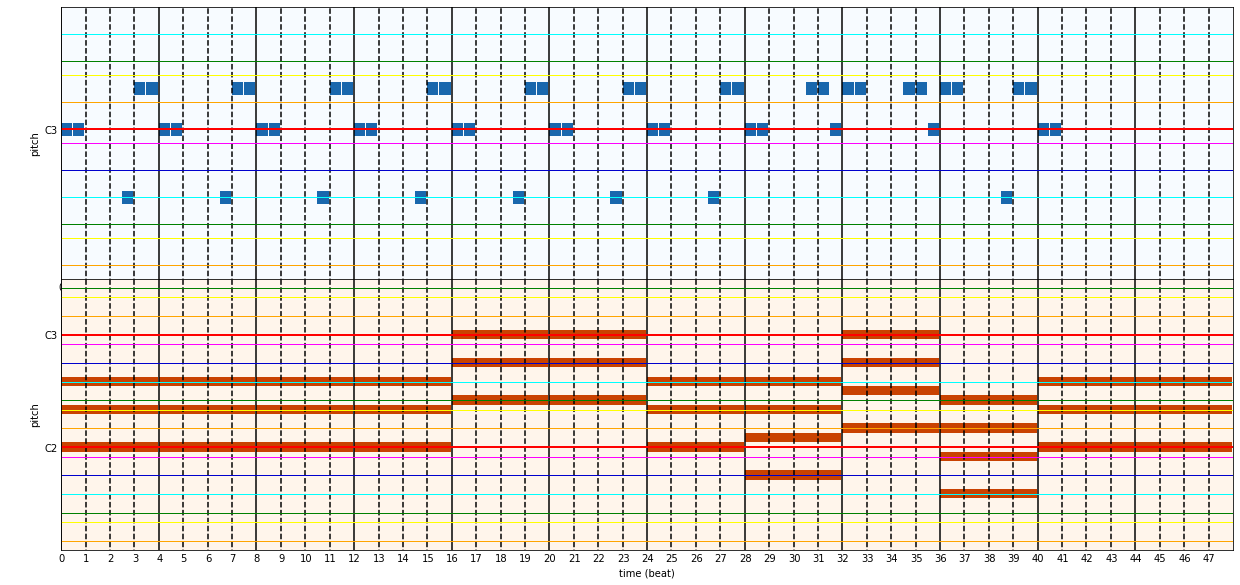

In [5]:
def get_sample():
    midi_path = os.path.join(input_dir, df['path'][0])
    ppr = Multitrack(midi_path)
    return ppr

grid_plot(get_sample())

## 処理フレームワーク
Processorを継承したクラスのインスタンスをPreprocessorへ与えてやることで前処理を行う  
ProcessorはリストでPypianorollProcessor.processへ渡され，pypianoroll.Multitrackとdataを順番に受け取っては処理していく  
最終的に得られたprocessed_melody(x, prev_x)とchordを合わせてnpzか何かで保存  
それを取り出してDatasetとして扱い，DataLoaderへ渡す腹積もり

In [6]:
class PypianorollProcessor(SequentialProcessor):
    """
    pypianoroll.Multitrackとその中で選択されたTrackに対して順次処理を行う
    """
    def __call__(self, ppr, tracks=None):
        if not isinstance(ppr, Multitrack): ppr = Multitrack(ppr)
        if tracks == None: tracks = list(range(len(ppr.tracks)))
        if not isinstance(tracks, list): tracks = [tracks]
        data = None
        for t in tracks:
            data = ppr.tracks[t]
            for processor in self.processors:
                ppr, data = processor(ppr, data)
        return ppr, data


def theorytab_preprocess(ppr, melody_processors=[], chord_processors=[]):
    """
    theorytabデータセットのデータに対し，メロディとコードへ指定の処理を行った結果を返す
    """
    ppr, processed_melody = PypianorollProcessor(melody_processors)(ppr, 0)
    ppr, processed_chord = PypianorollProcessor(chord_processors)(ppr, 1)
    return processed_melody, processed_chord

In [7]:
class TestProcessor(Processor):
    def __init__(self, number):
        self.number = number

    def __call__(self, ppr, data):
        print(f"test process {self.number}")
        return ppr, data

with Timer():
    ppr = get_sample()

with Timer():    
    melody, chord = theorytab_preprocess(ppr, TestProcessor(1), [TestProcessor(2), TestProcessor(3)])

0.006304
test process 1
test process 2
test process 3
0.000076


MIDIデータの読み込みに1/100secくらいかかるんだなぁ  
読込みだけで4分くらいかかるんだなぁ  
並列処理すればその限りではないけどなぁ

## 共通の前処理
- ベロシティは無視し，2値化する
- 最小ステップを16分音符にする
    - メロディのdown_resolutionするときの最初のステップにある音をそのステップの音とする
    - i.e. resolution: 24 -> 4なら，24 / 4 = 6ステップごとにある音をそのステップの音とする
    - 3連符や32分音符を取り除く
        - down_resolutionの過程で消える．(removeしていることにはなる．)
        - 3連符はつながっていればドレミ→ドドレミとなる
- メロディに音符のない小節は使用しない
- コードは，最初の12個を主音，最後をメジャーかマイナーの区別に使う．
    - 小節の最初のステップの和音を使い，1小節に1つのコードを割り当てる．
        - 分数コードや転回はないと踏む
        - コードトラックの小節の先頭で一番低い音をルートとする．
        - メジャーかマイナーかは次に低い音との距離で決定する．
- x:(bars, 16, 128), prev_x: (bars, 16, 128), chord: (bars, 13)のデータを得る
- 12個分のキーシフトを行うことでデータの水増しを行う
    - 上に11シフト

### ベロシティは無視し，2値化する

In [8]:
class Binalize(Processor):
    def __call__(self, ppr, track):
        ppr.binarize()
        track.binarize()
        return ppr, track

In [9]:
ppr = get_sample()
binalize = Binalize()

with Timer():
    ppr, track = binalize(ppr, ppr.tracks[0])
print(ppr.is_binarized(), track.is_binarized())

0.000100
True True


### resolutionを下げる

In [10]:
class DownBeatResolution(Processor):
    """
    全てのトラックのresolutionを下げるので注意
    """
    def __init__(self, resolution_to, resolution_from=None):
        self.res_to = resolution_to
        self.res_from = resolution_from
        
        if self.res_from is not None and self.res_to >= self.res_from:
            raise ValueError(f"Resolution_to (given: {self.res_to}) must be smaller than resolution_from (given: {self.res_from}).")
        
    def __call__(self, ppr, track):
        if self.res_from is None:
            if self.res_to >= ppr.beat_resolution:
                raise ValueError(f"Target resolution ({self.res_to}) must be smaller than the original resolution ({ppr.beat_resolution})")
            step_width = ppr.beat_resolution // self.res_to
        else:
            step_width = self.res_from // self.res_to
            
        ppr.beat_resolution = self.res_to
        ppr.downbeat = ppr.downbeat[::step_width]
        
        track_is_in_ppr = False
        for ppr_track in ppr.tracks:
            if ppr_track is track: track_is_in_ppr = True # isは参照の等価チェック
            ppr_track.pianoroll = ppr_track.pianoroll[::step_width]
        
        if not track_is_in_ppr:
            track.pianoroll = track.pianoroll[::step_width]
        
        return ppr, track

before -> resolution: 24, active length: 1151
0.000008
after: -> resolution: 4, active length: 192


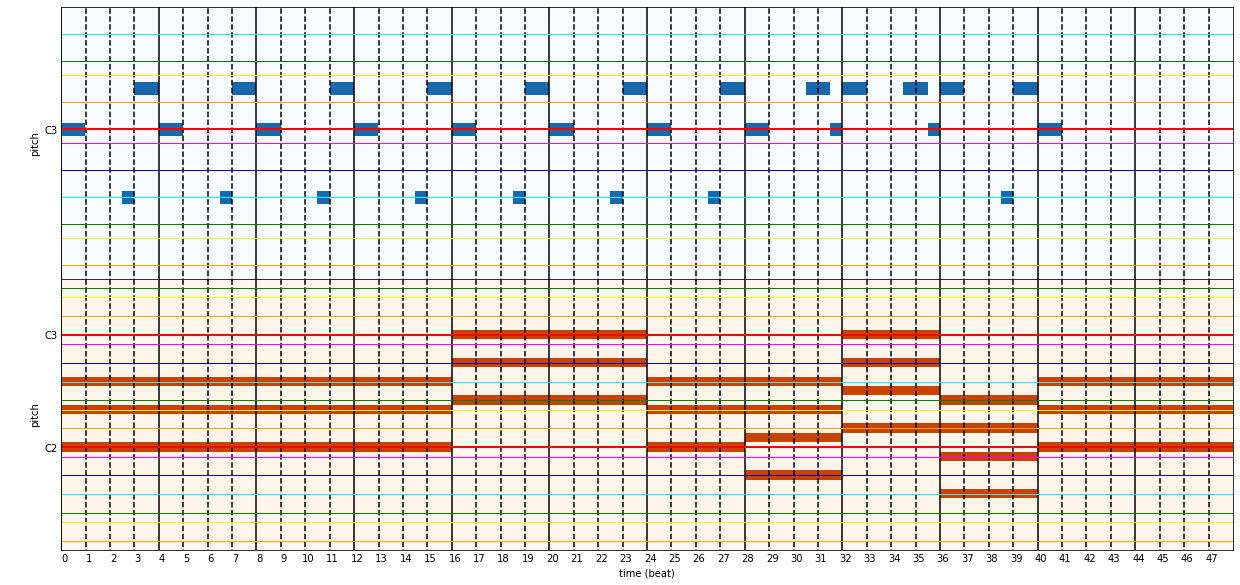

In [11]:
ppr = get_sample()
down_resolution = DownBeatResolution(4)

print(f"before -> resolution: {ppr.beat_resolution}, active length: {ppr.get_active_length()}")
with Timer():
    ppr, track = down_resolution(ppr, ppr.tracks[0])
print(f"after: -> resolution: {ppr.beat_resolution}, active length: {ppr.get_active_length()}")
grid_plot(ppr)

### メロディに音符のない小節は使用しない

In [12]:
class RemoveEmptyBars(Processor):
    def __init__(self, beats_in_bar=4):
        self.beats_in_bar = beats_in_bar
    
    def __call__(self, ppr, track):
        res = ppr.beat_resolution
        bar_res = self.beats_in_bar * res
        bars = int(np.ceil(len(ppr.downbeat) / bar_res))
        
        empty_steps = []
        for b in range(bars):
            if not track.pianoroll[b*bar_res:(b+1)*bar_res].any():
                empty_steps += list(range(b*bar_res, (b+1)*bar_res))
        
        ppr.downbeat = np.delete(ppr.downbeat, empty_steps)
        
        track_is_in_ppr = False
        for ppr_track in ppr.tracks:
            if ppr_track is track: track_is_in_ppr = True
            ppr_track.pianoroll = np.delete(ppr_track.pianoroll, empty_steps, axis=0)

        if not track_is_in_ppr:
            track.pianoroll = np.delete(track.pianoroll, empty_steps, axis=0)
                    
        return ppr, track

before -> active length: 1151
0.001067
after: -> active length: 1055


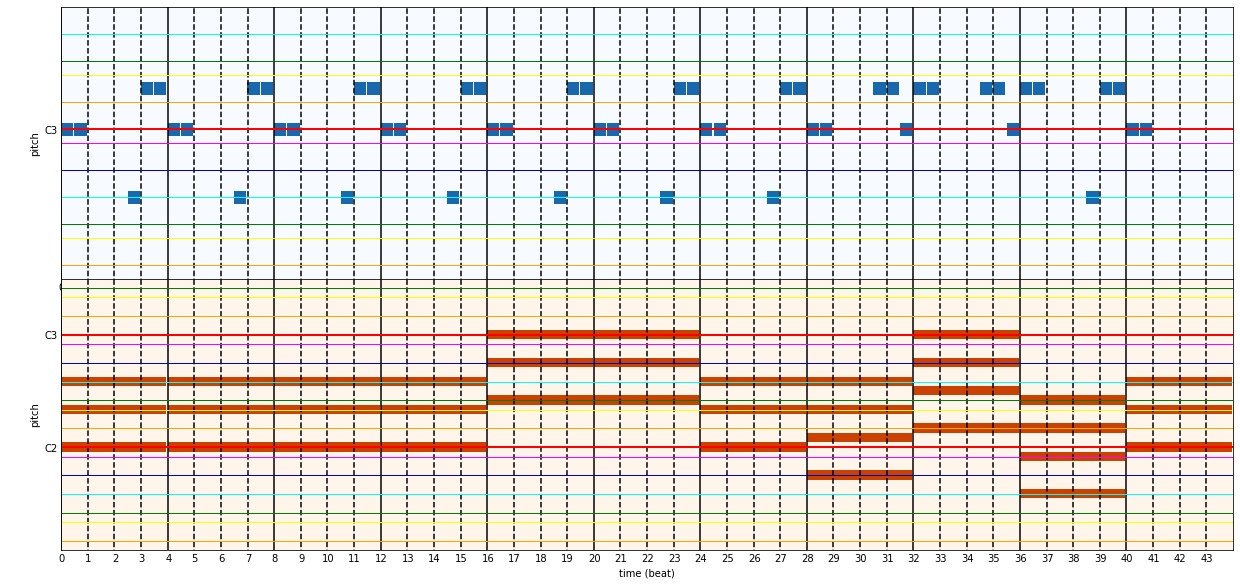

In [13]:
ppr = get_sample()
remove_empty_bars = RemoveEmptyBars()

print(f"before -> active length: {ppr.get_active_length()}")
with Timer():
    ppr, track = remove_empty_bars(ppr, ppr.tracks[0])
print(f"after: -> active length: {ppr.get_active_length()}")
grid_plot(ppr)

### コードベクトルの取得

In [14]:
class GetChordVectors(Processor):
    def __init__(self, minor=0, major=1, beats_in_bar=4):
        self.beats_in_bar = beats_in_bar
    
    def __call__(self, ppr, track):
        beat_res = ppr.beat_resolution
        bar_res = beat_res * self.beats_in_bar
        pianoroll = track.pianoroll
        
        chord_vecs = []
        for head in range(0, pianoroll.shape[0], bar_res):
            chord = np.where(pianoroll[head])[0]
            
            chord_vec = np.zeros(13)
            if len(chord) > 1:
                chord_vec[chord[0] % 12] = 1
                chord_vec[-1] = 0 if chord[1] - chord[0] == 3 else 1
            
            chord_vecs.append(chord_vec)
        
        return ppr, np.array(chord_vecs)

In [15]:
ppr = get_sample()
get_chord_vectors = GetChordVectors()

with Timer():
    ppr, chord_vecs = get_chord_vectors(ppr, ppr.tracks[1])
print(chord_vecs.shape)
for cv in chord_vecs:
    print(cv)

0.000086
(12, 13)
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


### メロディを小節ごとに分割

In [16]:
class GetBars(Processor):
    def __init__(self, beats_in_bar=4):
        self.beats_in_bar = beats_in_bar
    
    def __call__(self, ppr, track):
        beat_res = ppr.beat_resolution
        bar_res = beat_res * self.beats_in_bar
        pianoroll = track.pianoroll
        
        bars = []
        for head in range(0, pianoroll.shape[0], bar_res):
            bars.append(pianoroll[head:head+bar_res])
        
        return ppr, np.array(bars)

bar resolution: 96
0.000725
(12, 96, 128)


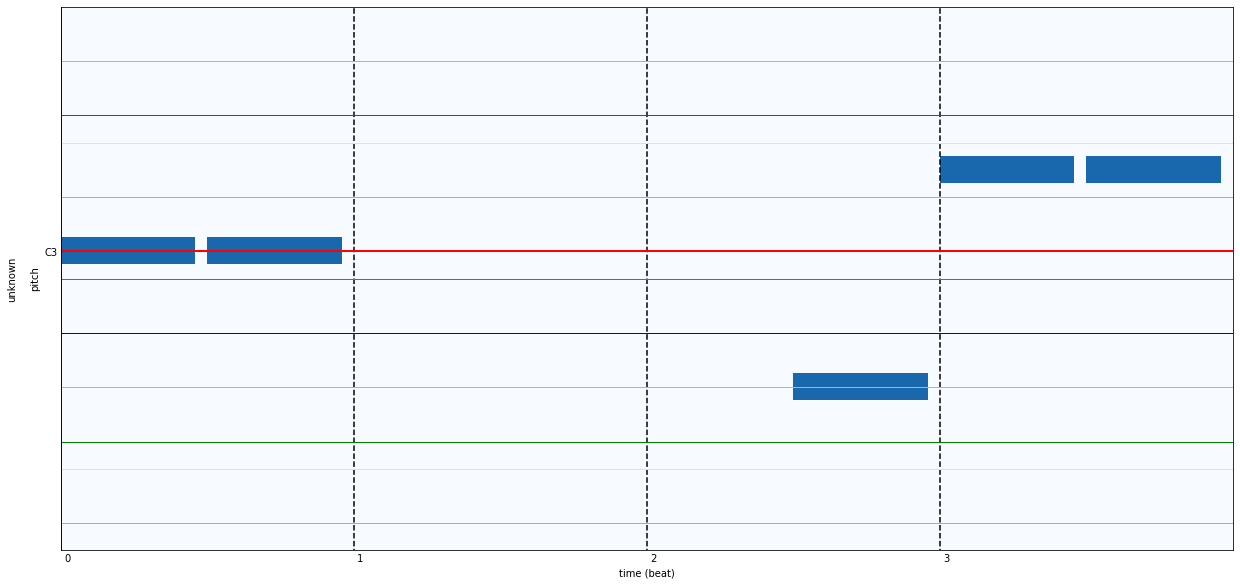

In [17]:
ppr = get_sample()
get_bars = GetBars()

print("bar resolution:", ppr.beat_resolution * 4)
with Timer():
    ppr, bars = get_bars(ppr, ppr.tracks[0])
print(bars.shape)
grid_plot(Track(pianoroll=bars[0]), beat_resolution=ppr.beat_resolution)

In [174]:
a = np.ones([10, 16, 128]) # bars, steps, pitches
result = a.tolist()
with Timer():
    s0, s1, s2 = a.shape
    a = a.T.tolist()
    empty = np.zeros([1,s1,s0]).tolist()
    for i in range(s2 - 1):
        a.pop(-1)
        a = empty + a
    a = np.array(a).T

# print(a)
print(a.shape)

0.010147
(10, 16, 128)


### キーシフトによるデータの水増し
- bars (bars, 16, 128) -> np.array(bars * 12, 16, 128)
- Track.pianoroll (length, 128) -> np.array(length * 12, 128)

1曲分の長さはpprから取得してもらうことにする

In [172]:
class AugumentMelody(Processor):
    def __init__(self, shifts=11, up=True):
        self.shifts = shifts
        self.up = up
    
    def __call__(self, ppr, bars):
        if isinstance(bars, Track): bars = bars.pianoroll
        
        augumented_bars = []
        if bars.ndim == 3:
            s0, s1, s2 = bars.shape
            bars = bars.T.tolist()
            augumented_bars += bars
            new_line = np.zeros([1,s1,s0]).tolist()
            for i in range(self.shifts):
                bars.pop(-1 if self.up else 0)
                bars = new_line + bars
                augumented_bars += bars
        elif bars.ndim == 2:
            pass
        else:
            raise ValueError("The bars to be augumented must have dimensions 2 or 3.")
        
        augumented_bars = np.array(augumented_bars).T
        return ppr, augumented_bars

In [173]:
ppr = get_sample()
augument = AugumentMelody()

ppr, bars = get_bars(ppr, ppr.tracks[0])
print("input shape:", bars.shape)
with Timer():
    ppr, bars = augument(ppr, bars)
print(bars.shape)
grid_plot(Track(pianoroll=bars[0]), beat_resolution=ppr.beat_resolution)

input shape: (12, 96, 128)
0.291263
(12, 96, 1536)


### 前小節データを得る
水増ししたものに対応する．  
「シフト→前小節」のほうが「前小節→シフト」よりもコストが少ない．  
前小節を取得するのは配列範囲の選択でいいが，二倍になった小節をシフトするのはコストがかかる

In [ ]:
# なんか分岐装置的な奴
def get_prev_x

### 基本処理計測

0.000082
0.000013
0.001126
0.000070
0.000146


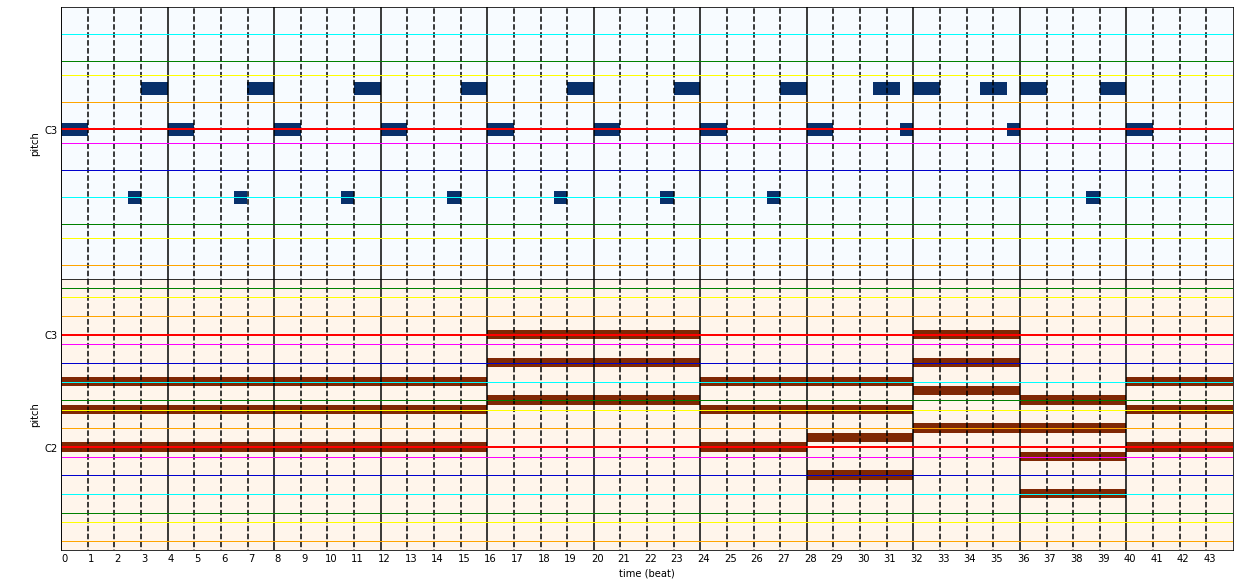

In [137]:
ppr = get_sample()
track = ppr.tracks[0]

for p in [binalize, down_resolution, remove_empty_bars, get_bars]:
    with Timer():
        ppr, track = p(ppr, track)

with Timer():
    ppr, chord_vecs = get_chord_vector(ppr, ppr.tracks[1])

grid_plot(ppr)

## original
- トライアドコード以外のコードを含む楽譜を取り除く
- 休符が後ろについている場合は音符の長さをその分伸ばす
- 小節の頭が休符の場合は2番目の音符を前に伸ばす
- メロディをC4～C5(C6?)までの2オクターブの中にシフト(でも128音使う．これによりモード崩壊しているかを判定できるらしい)